In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import sys
sys.path.append('/Users/koush/Projects/scLDL/src')

import scanpy as sc
import numpy as np
import pandas as pd
import torch
import anndata
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from scLDL.models.label_enhancer import LabelEnhancer
from scLDL.models.trainer import LabelEnhancerTrainer
from scLDL.utils.data import scDataset
from scLDL.utils.metrics import compute_metrics
from scLDL.utils.data import split_adata

In [5]:
adata = sc.read_h5ad(
    "../data/adata.h5ad")

# adata = sc.read_h5ad('/tmp/slideseq_mouse_lymphnode.h5ad')

adata, adata_test = split_adata(adata)
adata

AnnData object with n_obs × n_vars = 4622 × 3333
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'banksy_celltypes'
    uns: 'cell_thresholds', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl'
    obsm: 'X_umap', 'spatial', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count'

In [7]:
adata.obs = adata.obs.join(pd.read_csv(
    "/Users/koush/Projects/scLDL/data/tonsil_cell_types.csv").set_index(
        "NAME"))

adata_test.obs = adata_test.obs.join(pd.read_csv(
    "/Users/koush/Projects/scLDL/data/tonsil_cell_types.csv").set_index(
        "NAME"))

In [8]:
def encode_labels(labels, reverse_dict=True):
    unique_labels = sorted(list(set(labels)))
    if reverse_dict:
        return {label: i for i, label in enumerate(unique_labels)}
    return {i: label for i, label in enumerate(unique_labels)}

In [9]:
adata.obs['cell_type'] = adata.obs['cell_type_2'].copy()
adata.obs['cell_type_int'] = adata.obs['cell_type'].replace(
    encode_labels(adata.obs['cell_type']))


adata_test.obs['cell_type'] = adata_test.obs['cell_type_2'].copy()
adata_test.obs['cell_type_int'] = adata_test.obs['cell_type'].replace(
    encode_labels(adata_test.obs['cell_type']))

/var/folders/jr/19l2mwvs76v4rv5vy8j4vrch0000gn/T/ipykernel_57236/3405395688.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adata.obs['cell_type_int'] = adata.obs['cell_type'].replace(
/var/folders/jr/19l2mwvs76v4rv5vy8j4vrch0000gn/T/ipykernel_57236/3405395688.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adata_test.obs['cell_type_int'] = adata_test.obs['cell_type'].replace(


In [5]:
# sc.pp.pca(adata)
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)

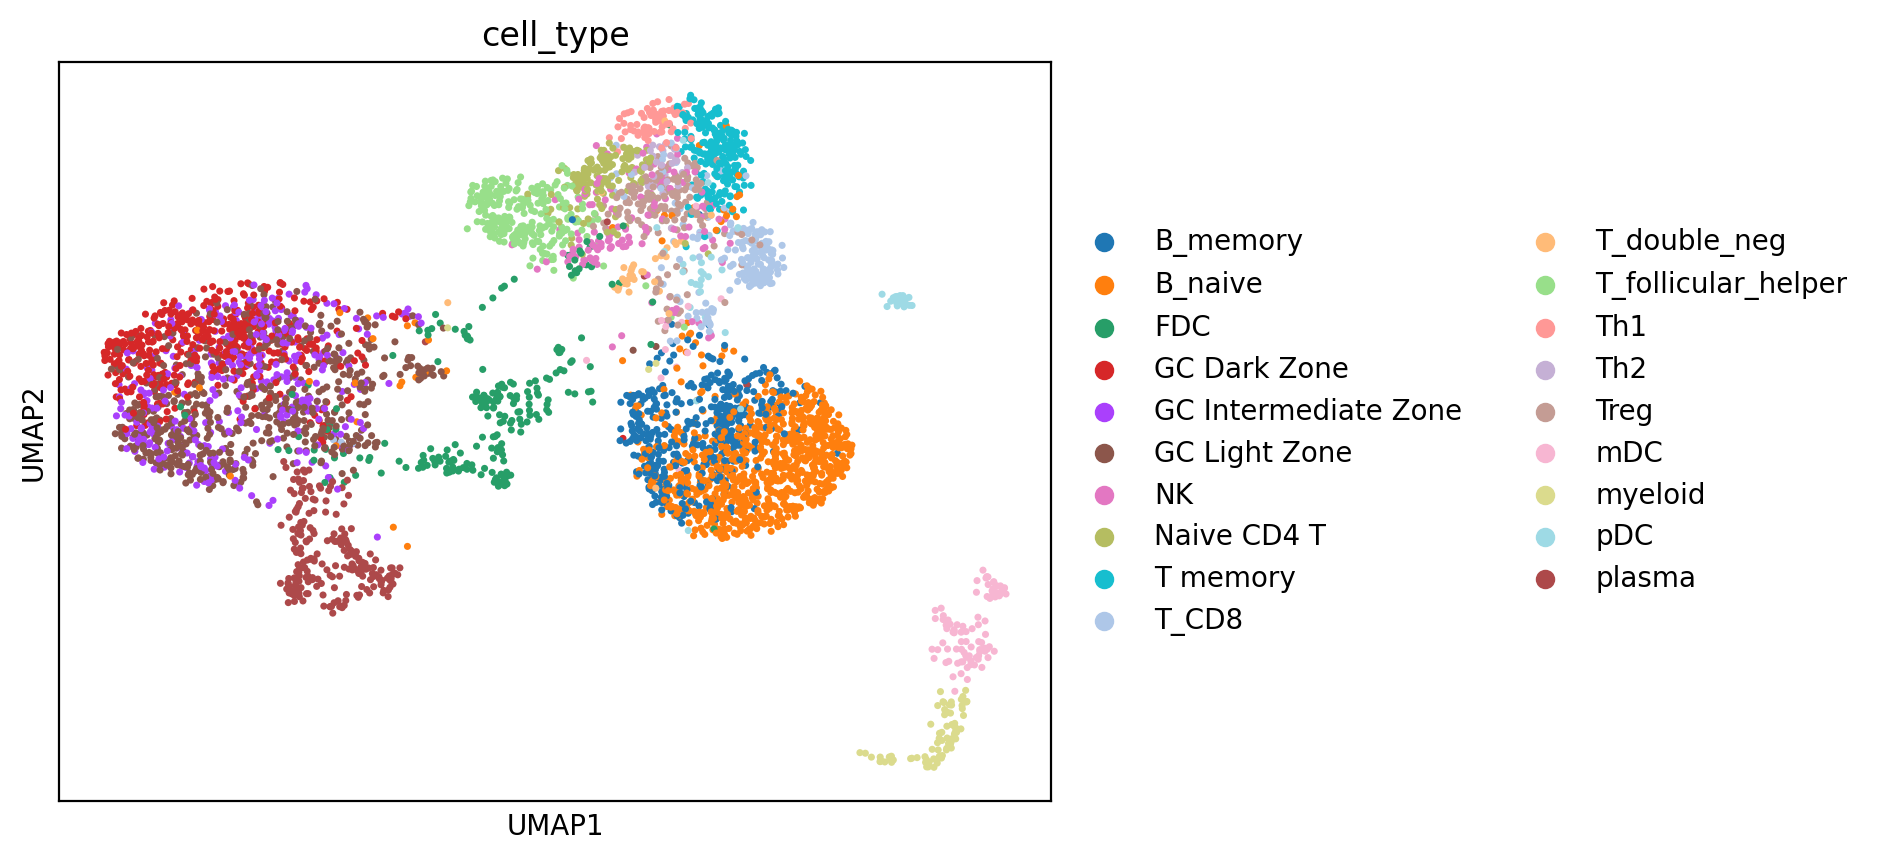

In [10]:
sc.pl.umap(adata, color='cell_type')

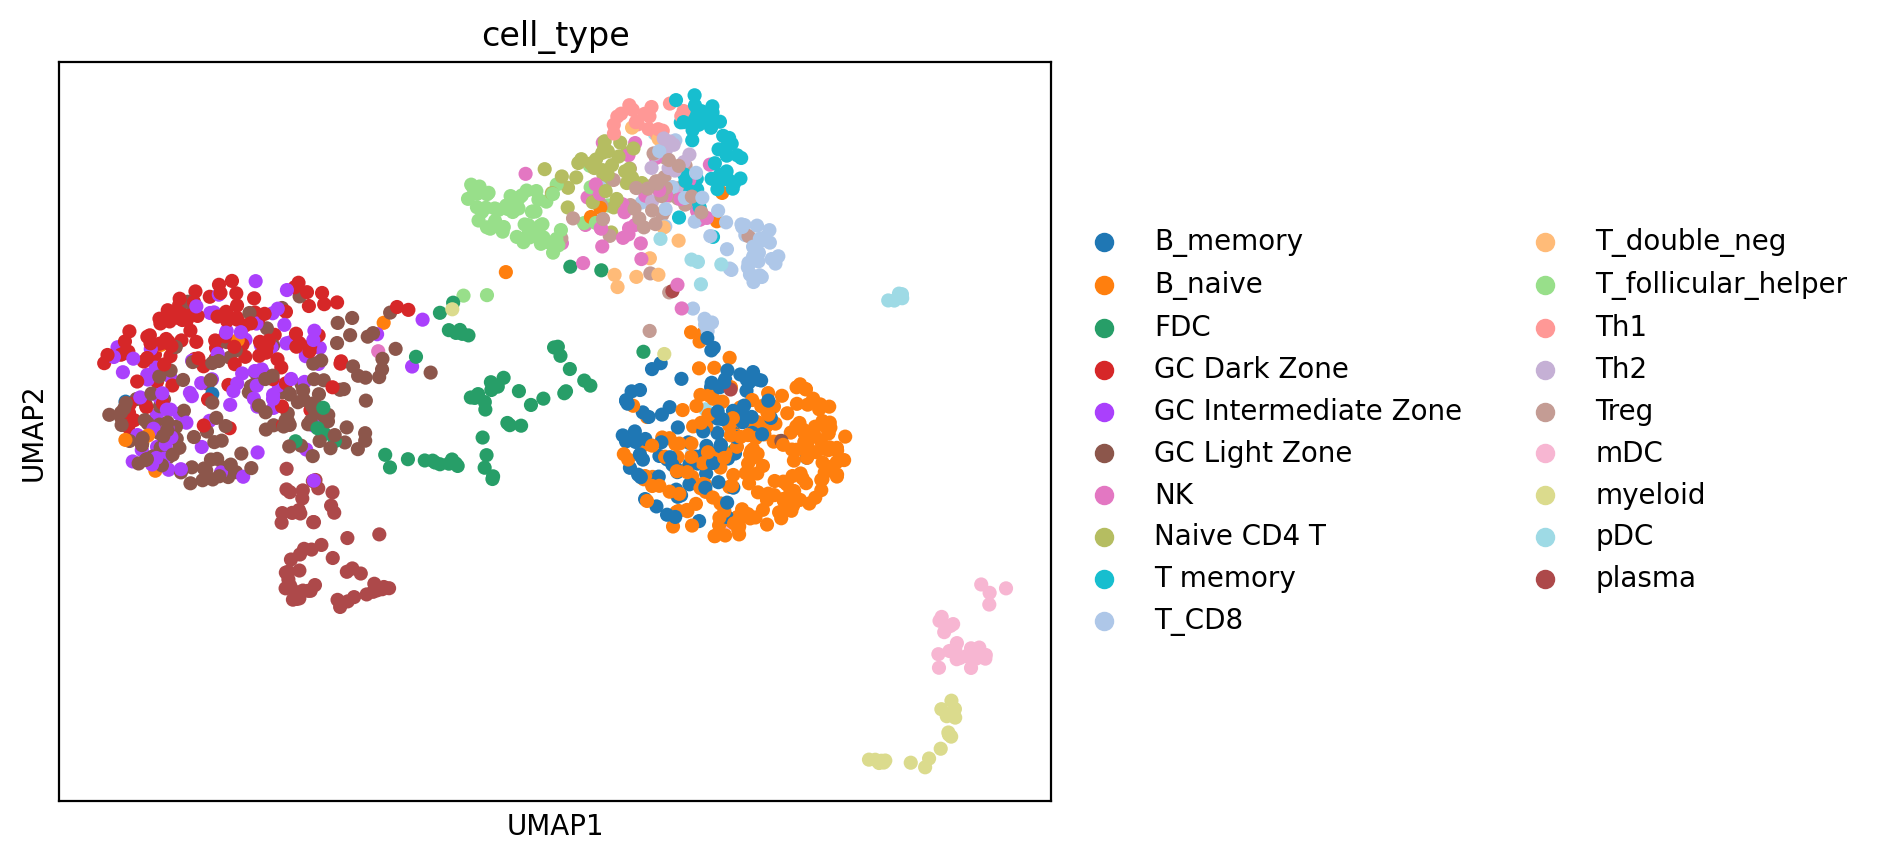

In [11]:
sc.pl.umap(adata_test, color='cell_type')

In [13]:
n_obs = adata.shape[0]
n_classes = len(adata.obs['cell_type'].unique())
labels = adata.obs['cell_type'].cat.codes.values


In [14]:
y_true = labels.astype(np.float32)

In [25]:
from torch.utils.data import DataLoader, random_split

dataset = scDataset(adata, layer='normalized_count', label_key='cell_type', spatial_key='spatial')

# Define split sizes
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LabelEnhancer(
    x_dim=dataset.get_input_dim(),
    d_dim=dataset.get_num_classes(),
    h_dim=128,
    device=device
)

print("\nStarting Training...")
trainer = LabelEnhancerTrainer(
    model, 
    lr=3e-4, 
    beta=0.001, 
    lambda_gap=1.0, 
    lambda_spatial=0.1
)

trainer.train(train_loader, epochs=500, log_interval=25)


Starting Training...
Starting Main Training for 500 epochs...
Epoch 25: Avg Loss = -2.2483
Epoch 50: Avg Loss = -1.7707
Epoch 75: Avg Loss = -2.1813
Epoch 100: Avg Loss = -2.9474
Epoch 125: Avg Loss = -1.7685
Epoch 150: Avg Loss = -3.0290
Epoch 175: Avg Loss = -4.1837
Epoch 200: Avg Loss = -3.4975
Epoch 225: Avg Loss = -3.7864
Epoch 250: Avg Loss = -4.0438
Epoch 275: Avg Loss = -4.2246
Epoch 300: Avg Loss = -5.3789
Epoch 325: Avg Loss = -5.8018
Epoch 350: Avg Loss = -6.0740
Epoch 375: Avg Loss = -6.6373
Epoch 400: Avg Loss = -6.4626
Epoch 425: Avg Loss = -6.6524
Epoch 450: Avg Loss = -7.5876
Epoch 475: Avg Loss = -7.1855
Epoch 500: Avg Loss = -7.3463


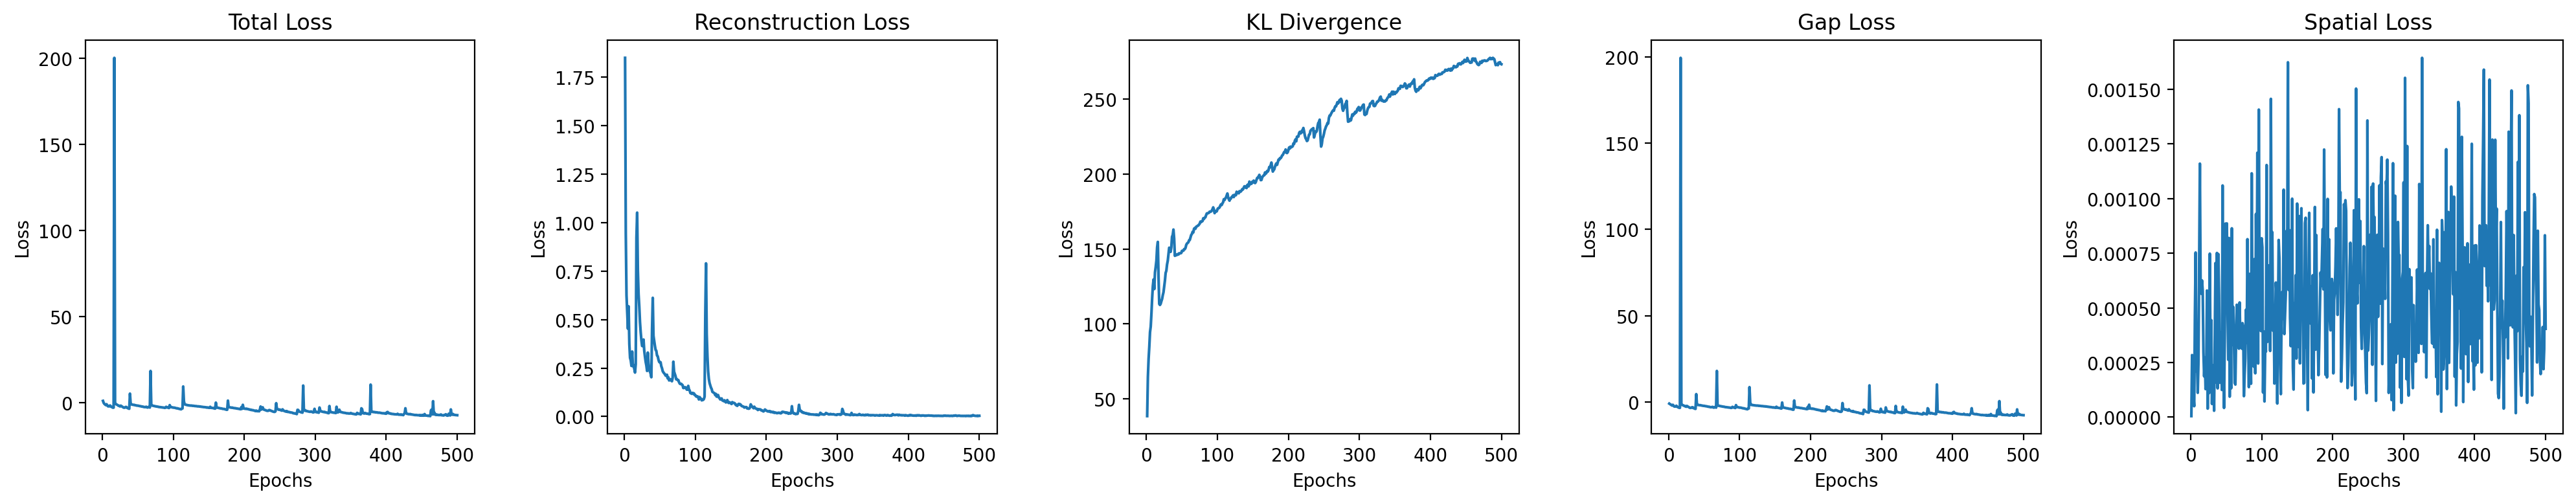

In [29]:
trainer.plot_losses()

In [18]:
import anndata as ad

In [30]:
distributions = trainer.predict(train_loader)
adata.obsm['X_label_enhanced'] = distributions
print("\nEvaluating Performance...")
metrics = compute_metrics(y_true, distributions)
print("Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

ValueError: Value passed for key 'X_label_enhanced' is of incorrect shape. Values of obsm must match dimensions ('obs',) of parent. Value had shape (4622,) while it should have had (5778,).

In [31]:
distributions = trainer.predict(test_loader)
adata.obsm['X_label_enhanced'] = distributions
print("\nEvaluating Performance...")
metrics = compute_metrics(y_true, distributions)
print("Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


ValueError: Value passed for key 'X_label_enhanced' is of incorrect shape. Values of obsm must match dimensions ('obs',) of parent. Value had shape (1156,) while it should have had (5778,).

In [32]:
z = trainer.get_latent(test_loader)
adata_z = ad.AnnData(z)
# adata_z.obs = adata.obs.copy()
sc.pp.pca(adata_z)
sc.pp.neighbors(adata_z)
sc.tl.umap(adata_z)


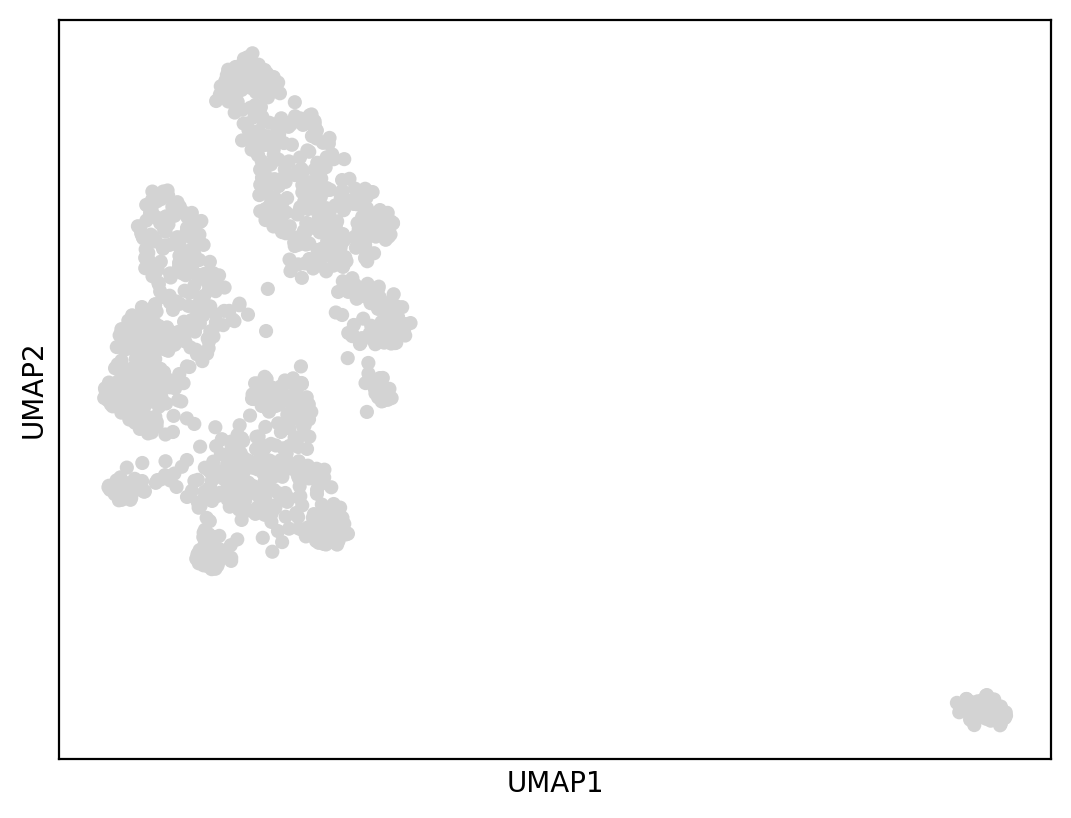

In [33]:
sc.pl.umap(adata_z)

In [34]:
label_dict = encode_labels(adata.obs['cell_type'], reverse_dict=False)

In [35]:
def plot_examples_by_cell_type(adata, n_examples=5, annot='cell_type'):
    if annot in adata.obs:
        unique_cell_types = adata.obs[annot].unique()
        label_col = annot
    else:
        unique_cell_types = adata.obs['cell_type_int'].unique()
        label_col = 'cell_type_int'
        
    n_classes = len(unique_cell_types)

    # Create subplots: rows = cell types, cols = examples
    fig, axes = plt.subplots(n_classes, n_examples, figsize=(3 * n_examples, 2 * n_classes), dpi=120)
    
    # Ensure axes is always 2D for consistent indexing
    axes = np.array(axes).reshape(n_classes, n_examples)

    for i, cell_type in enumerate(unique_cell_types):
        # Find indices for this cell type
        type_indices = np.where(adata.obs[label_col] == cell_type)[0]
        
        # Select random examples
        if len(type_indices) >= n_examples:
            selected_indices = np.random.choice(type_indices, n_examples, replace=False)
        else:
            # Handle case with fewer cells than examples by replacement
            selected_indices = np.random.choice(type_indices, n_examples, replace=True)
            
        for j, idx in enumerate(selected_indices):
            ax = axes[i, j]
            
            # Plot the data if available
            if 'X_label_enhanced' in adata.obsm:
                # Assuming X_label_enhanced[idx] is 1D or 2D array compatible with plot.bar
                data = pd.DataFrame(adata.obsm['X_label_enhanced'][idx])
                data.plot.bar(ax=ax, legend=False, alpha=1)
            
            # Set row label on the first column only
            if j == 0:
                ax.set_ylabel(str(cell_type), rotation=0, labelpad=40, fontsize=10, fontweight='bold', va='center', ha='right')
            
            ax.set_title(f"Idx: {idx}", fontsize=8)
            ax.set_xticks([]) # Hide x-ticks
            ax.set_yticks([]) # Hide y-ticks for cleaner look
            
            # Remove spines for cleaner look
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

# Usage:
# plot_examples_by_cell_type(adata)

In [36]:
plot_examples_by_cell_type(adata, n_examples=20, annot='cell_type')

In [80]:
adata.obs = adata.obs.join(
    pd.DataFrame(adata.obsm['X_label_enhanced'], 
    index=adata.obs_names, 
    columns=[v for k, v in label_dict.items()])
)

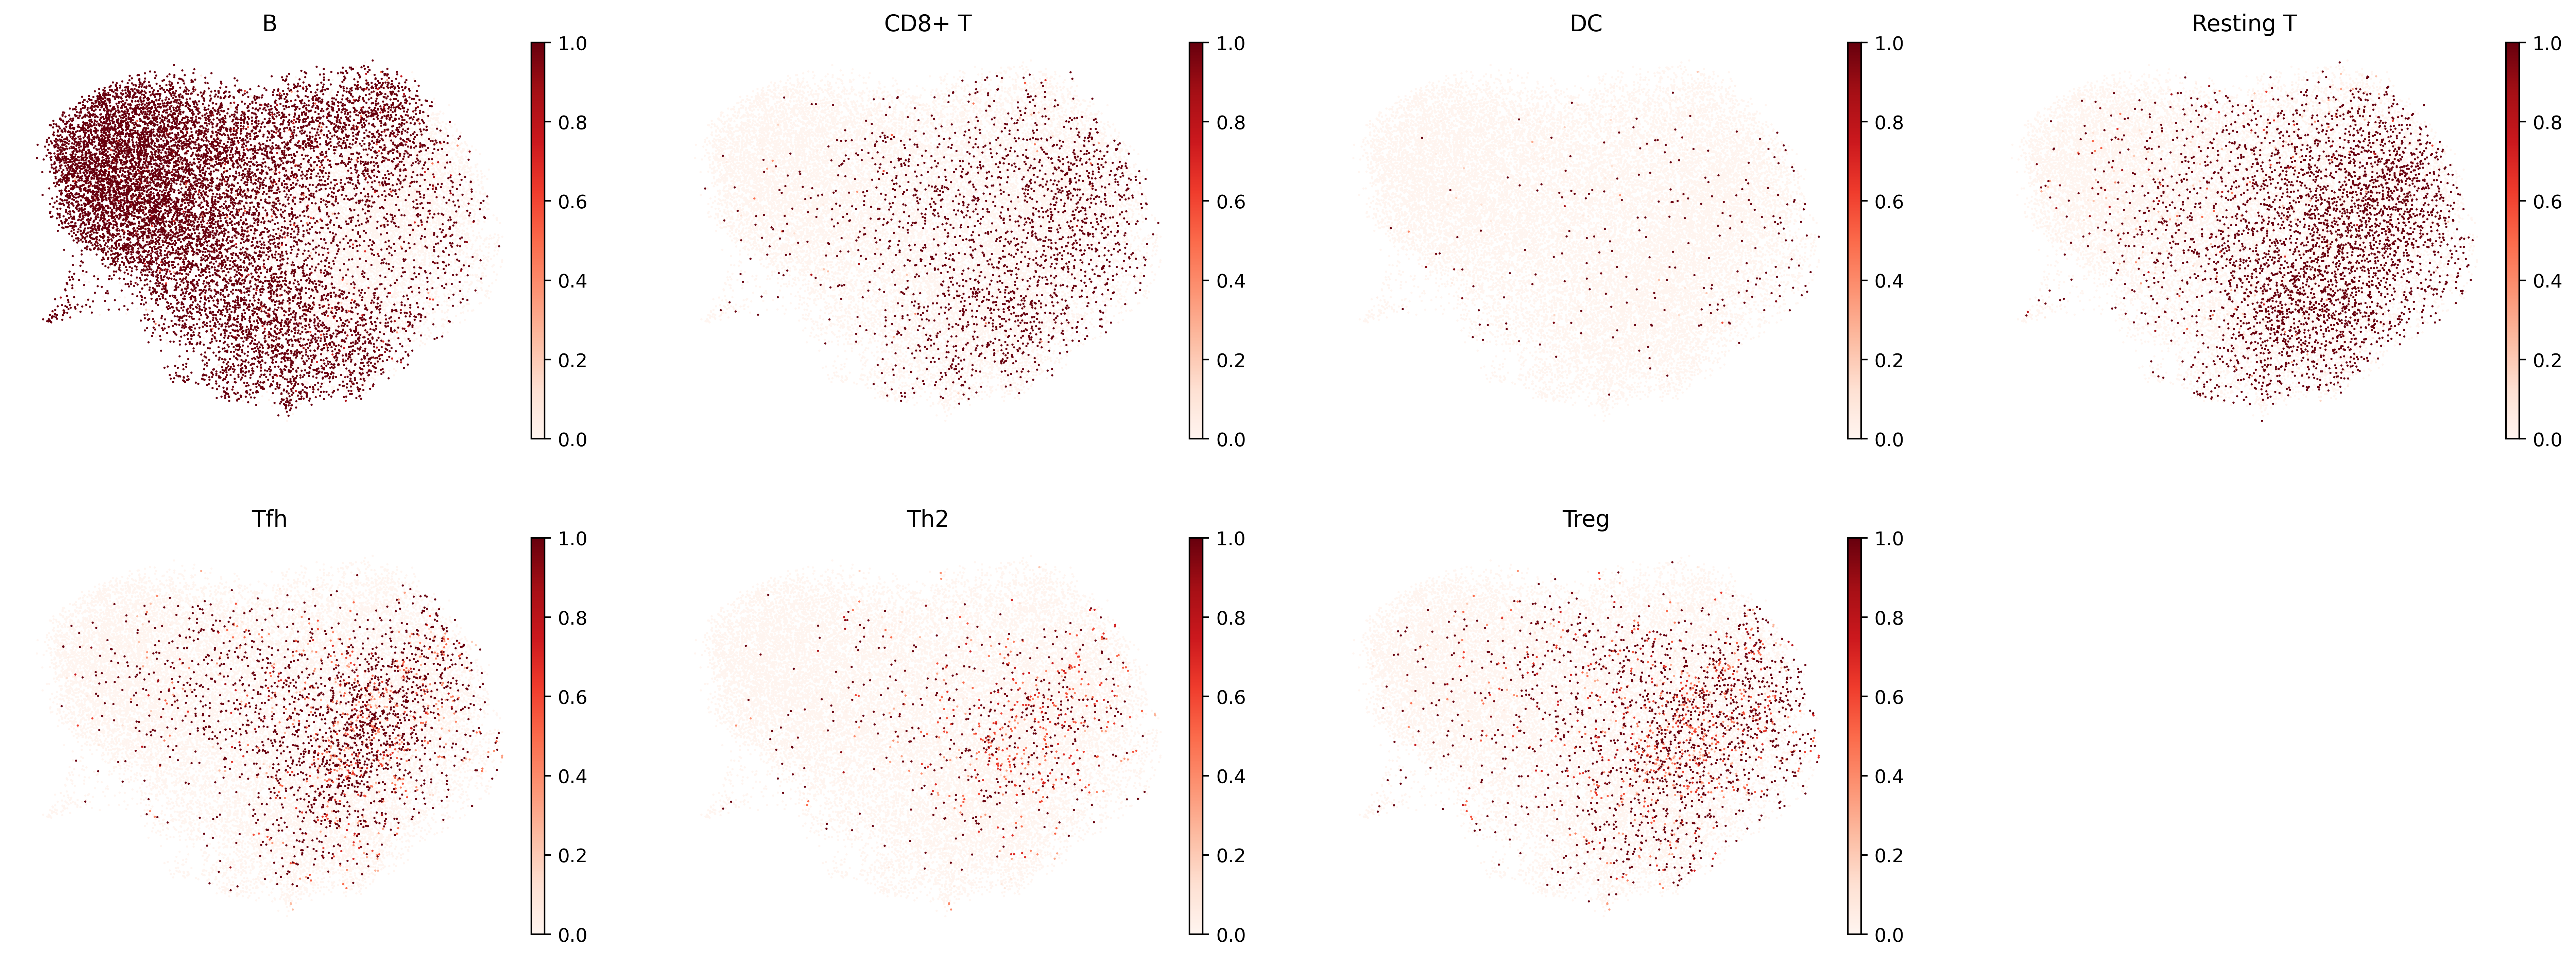

In [81]:
plt.rcParams['figure.figsize'] = (5, 4)
plt.rcParams['figure.dpi'] = 200
sc.pl.umap(adata, color=[v for k, v in label_dict.items()], frameon=False, cmap='Reds')